# eICU Collaborative Research Database

# Notebook 5: Prediction

This notebook explores how a decision trees can be trained to predict in-hospital mortality of patients.


## Load libraries and connect to the database

In [0]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# model building
from sklearn import ensemble, impute, metrics, preprocessing, tree
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

# Make pandas dataframes prettier
from IPython.display import display, HTML, Image
plt.rcParams.update({'font.size': 20})
%matplotlib inline
plt.style.use('ggplot')

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [0]:
# authenticate
auth.authenticate_user()

In [0]:
# Set up environment variables
project_id='aarhus-critical-2019-team'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

To make our lives easier, we'll also install and import a set of helper functions from the `datathon2` package. We will be using the following functions from the package:
- `plot_model_pred_2d`: to visualize our data, helping to display a class split assigned by a tree vs the true class.
- `run_query()`: to run an SQL query against our BigQuery database and assign the results to a dataframe. 


In [4]:
!pip install glowyr

In [0]:
import glowyr as dtn
import pydotplus
from tableone import TableOne

In this notebook we'll be looking at tree models, so we'll now install a package for visualizing these models.

In [6]:
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


## Load the patient cohort

Let's extract a cohort of patients admitted to the ICU from the emergency department.  We link demographics data from the `patient` table to severity of illness score data in the `apachepatientresult` table. We exclude readmissions and neurological patients to help create a population suitable for our demonstration.

In [0]:
# Link the patient, apachepatientresult, and apacheapsvar tables on patientunitstayid
# using an inner join.
query = """
SELECT p.unitadmitsource, p.gender, p.age, p.unittype, p.unitstaytype, 
    a.actualhospitalmortality, a.acutePhysiologyScore, a.apacheScore
FROM `physionet-data.eicu_crd_demo.patient` p
INNER JOIN `physionet-data.eicu_crd_demo.apachepatientresult` a
ON p.patientunitstayid = a.patientunitstayid
WHERE a.apacheversion LIKE 'IVa'
AND LOWER(p.unitadmitsource) LIKE "%emergency%"
AND LOWER(p.unitstaytype) LIKE "admit%"
AND LOWER(p.unittype) NOT LIKE "%neuro%";
"""

cohort = dtn.run_query(query,project_id)

In [8]:
cohort.head()

,unitadmitsource,gender,age,unittype,unitstaytype,actualhospitalmortality,acutePhysiologyScore,apacheScore
0,Emergency Department,Female,48,Med-Surg ICU,admit,ALIVE,44,49
1,Emergency Department,Female,59,MICU,admit,ALIVE,56,61
2,Emergency Department,Male,31,MICU,admit,ALIVE,45,45
3,Emergency Department,Female,51,Med-Surg ICU,admit,ALIVE,19,24
4,Emergency Department,Female,48,Med-Surg ICU,admit,ALIVE,25,30


## Preparing the data for analysis

Before continuing, we want to review our data, paying attention to factors such as:
- data types (for example, are values recorded as characters or numerical values?) 
- missing data
- distribution of values

In [9]:
# dataset info
print(cohort.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 8 columns):
unitadmitsource            536 non-null object
gender                     536 non-null object
age                        536 non-null object
unittype                   536 non-null object
unitstaytype               536 non-null object
actualhospitalmortality    536 non-null object
acutePhysiologyScore       536 non-null int64
apacheScore                536 non-null int64
dtypes: int64(2), object(6)
memory usage: 33.6+ KB
None


In [0]:
# Encode the categorical data
encoder = preprocessing.LabelEncoder()
cohort['gender_code'] = encoder.fit_transform(cohort['gender'])
cohort['actualhospitalmortality_code'] = encoder.fit_transform(cohort['actualhospitalmortality'])


In the eICU Collaborative Research Database, ages >89 years have been removed to comply with data sharing regulations. We will need to decide how to handle these ages. For simplicity, we will assign an age of 91.5 years to these patients.

In [0]:
# Handle the deidentified ages
cohort['age'] = pd.to_numeric(cohort['age'], downcast='integer', errors='coerce')
cohort['age'] = cohort['age'].fillna(value=91.5)

In [12]:
# Preview the encoded data
cohort[['gender','gender_code']].head()

,gender,gender_code
0,Female,0
1,Female,0
2,Male,1
3,Female,0
4,Female,0


In [13]:
# Check the outcome variable
cohort['actualhospitalmortality_code'].unique()

array([0, 1])

Now let's use the [tableone package](https://doi.org/10.1093/jamiaopen/ooy012
) to review our dataset.

In [14]:
# View summary statistics
pd.set_option('display.max_rows', 500)
TableOne(cohort,groupby='actualhospitalmortality')

Grouped by actualhospitalmortality                          
                                                                              isnull        ALIVE      EXPIRED
variable                     level                                                                            
n                                                                                             488           48
unitadmitsource              Emergency Department                                  0  488 (100.0)   48 (100.0)
gender                       Female                                                0   281 (57.6)    24 (50.0)
                             Male                                                      207 (42.4)    23 (47.9)
                             Unknown                                                                   1 (2.1)
age                                                                                0  62.2 (17.4)  75.2 (12.6)
unittype                     CCU-CTICU                                             0     23 (4.7)      2 (4.2)
                             CSICU                                                        3 (0.6)             
                             CTICU                                                        9 (1.8)      1 (2.1)
                             Cardiac ICU                                                 25 (5.1)     7 (14.6)
                             MICU                                                       53 (10.9)      1 (2.1)
                             Med-Surg ICU                                              359 (73.6)    34 (70.8)
                             SICU                                                        16 (3.3)      3 (6.2)
unitstaytype                 admit                                                 0  488 (100.0)   48 (100.0)
actualhospitalmortality      ALIVE                                                 0  488 (100.0)             
                             EXPIRED                                                                48 (100.0)
acutePhysiologyScore                                                               0  38.5 (18.8)  74.3 (31.7)
apacheScore                                                                        0  49.9 (21.1)  91.8 (30.5)
gender_code                  0                                                     0   281 (57.6)    24 (50.0)
                             1                                                         207 (42.4)    23 (47.9)
                             2                                                                         1 (2.1)
actualhospitalmortality_code 0                                                     0  488 (100.0)             
                             1                                                                      48 (100.0)
[1] Warning, test for normality reports non-normal distributions for: acutePhysiologyScore, age, apacheScore.

From these summary statistics, we can see that the average age is higher in the group of patients who do not survive. What other differences do you see?

## Creating our train and test sets

We only focus on two variables for our analysis, age and acute physiology score. Limiting ourselves to two variables will make it easier to visualize our models.

In [0]:
features = ['age','acutePhysiologyScore']
outcome = 'actualhospitalmortality_code'

X = cohort[features]
y = cohort[outcome]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [17]:
# Review the number of cases in each set
print("Train data: {}".format(len(X_train)))
print("Test data: {}".format(len(X_test)))

Train data: 428
Test data: 108


## Decision trees

Let's build the simplest tree model we can think of: a classification tree with only one split. Decision trees of this form are commonly referred to under the umbrella term Classification and Regression Trees (CART) [1]. 

While we will only be looking at classification here, regression isn't too different. After grouping the data (which is essentially what a decision tree does), classification involves assigning all members of the group to the majority class of that group during training. Regression is the same, except you would assign the average value, not the majority. 

In the case of a decision tree with one split, often called a "stump", the model will partition the data into two groups, and assign classes for those two groups based on majority vote. There are many parameters available for the DecisionTreeClassifier class; by specifying max_depth=1 we will build a decision tree with only one split - i.e. of depth 1.

[1] L. Breiman, J. Friedman, R. Olshen, and C. Stone. Classification and Regression Trees. Wadsworth, Belmont, CA, 1984.

In [0]:
# specify max_depth=1 so we train a stump, i.e. a tree with only 1 split
mdl = tree.DecisionTreeClassifier(max_depth=1)

# fit the model to the data - trying to predict y from X
mdl = mdl.fit(X_train,y_train)

Our model is so simple that we can look at the full decision tree.

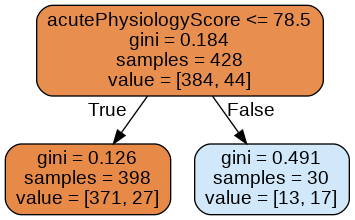

In [19]:
graph = dtn.create_graph(mdl,feature_names=features)
Image(graph.create_png())

Here we see three nodes: a node at the top, a node in the lower left, and a node in the lower right.

The top node is the root of the tree: it contains all the data. Let's read this node bottom to top:
- `value = [384, 44]`:  Current class balance. There are 384 observations of class 0 and 44 observations of class 1.
- `samples = 428`:  Number of samples assessed at this node.
- `gini = 0.184`: Gini impurity, a measure of "impurity". The higher the value, the bigger the mix of classes. A 50/50 split of two classes would result in an index of 0.5.
- `acutePhysiologyScore <=78.5`: Decision rule learned by the node. In this case, patients with a score of <= 78.5 are moved into the left node and >78.5 to the right. 

The gini impurity is actually used by the algorithm to determine a split. The model evaluates every feature (in our case, age and score) at every possible split (46, 47, 48..) to find the point with the lowest gini impurity in two resulting nodes. 

The approach is referred to as "greedy" because we are choosing the optimal split given our current state. Let's take a closer look at our decision boundary.

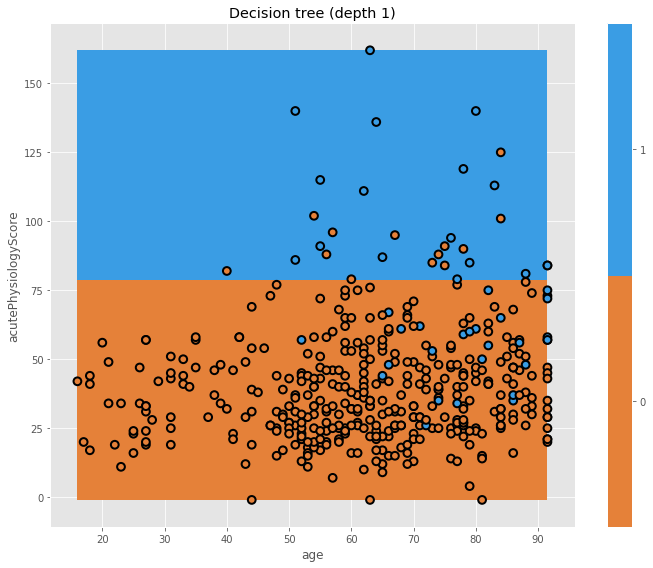

In [20]:
# look at the regions in a 2d plot
# based on scikit-learn tutorial plot_iris.html
plt.figure(figsize=[10,8])
dtn.plot_model_pred_2d(mdl, X_train, y_train, 
                       title="Decision tree (depth 1)")

In this plot we can see the decision boundary on the y-axis, separating the predicted classes. The true classes are indicated at each point. Where the background and point colours are mismatched, there has been misclassification. Of course we are using a very simple model. Let's see what happens when we increase the depth.

In [0]:
mdl = tree.DecisionTreeClassifier(max_depth=5)
mdl = mdl.fit(X_train,y_train)

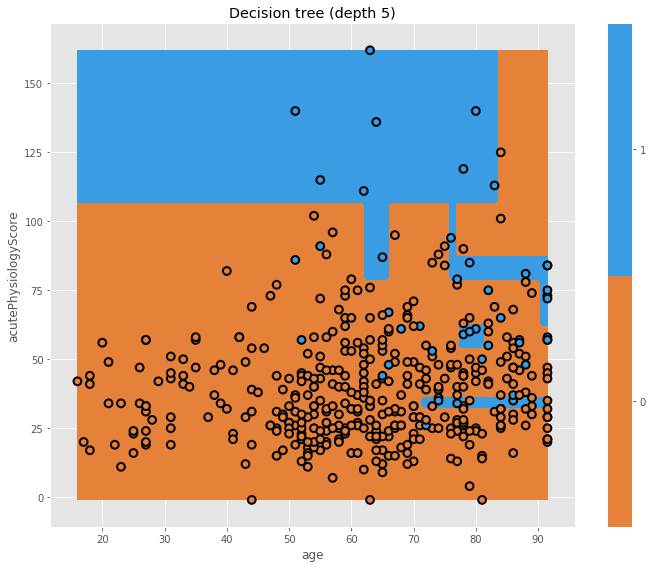

In [22]:
plt.figure(figsize=[10,8])
dtn.plot_model_pred_2d(mdl, X_train, y_train,
                      title="Decision tree (depth 5)")

Now our tree is more complicated! We can see a few vertical boundaries as well as the horizontal one from before. Some of these we may like, but some appear unnatural. Let's look at the tree itself.

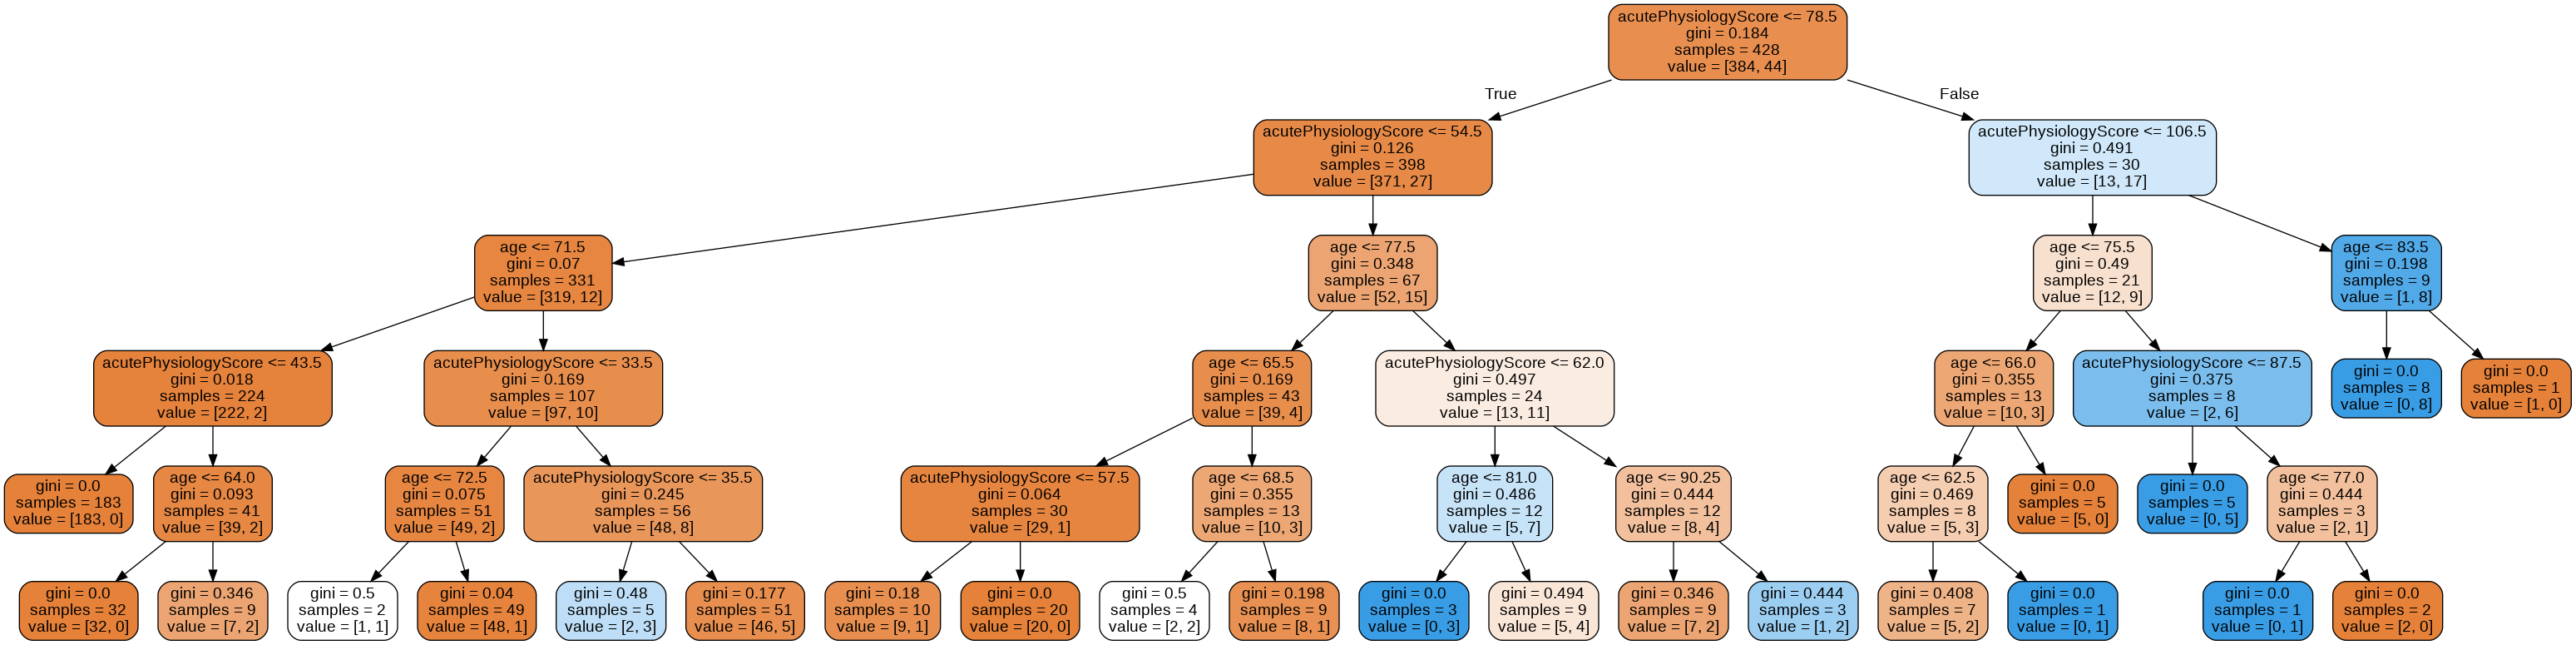

In [23]:
graph = dtn.create_graph(mdl,feature_names=features)
Image(graph.create_png())

Looking at the tree, we can see that there are some very specific rules. Consider our patient aged 65 years with an acute physiology score of 87. From the top of the tree, we would work our way down:

- acutePhysiologyScore <= 78.5? No.
- acutePhysiologyScore <= 106.5? Yes.
- age <= 75.5? Yes
- age <= 66. Yes.
- age <= 62.5? No. 

This leads us to our single node with a gini impurity of 0. Having an entire rule based upon this one observation seems silly, but it is perfectly logical as at the moment. The only objective the algorithm cares about is minimizing the gini impurity. 

We are at risk of overfitting our data! This is where "pruning" comes in.

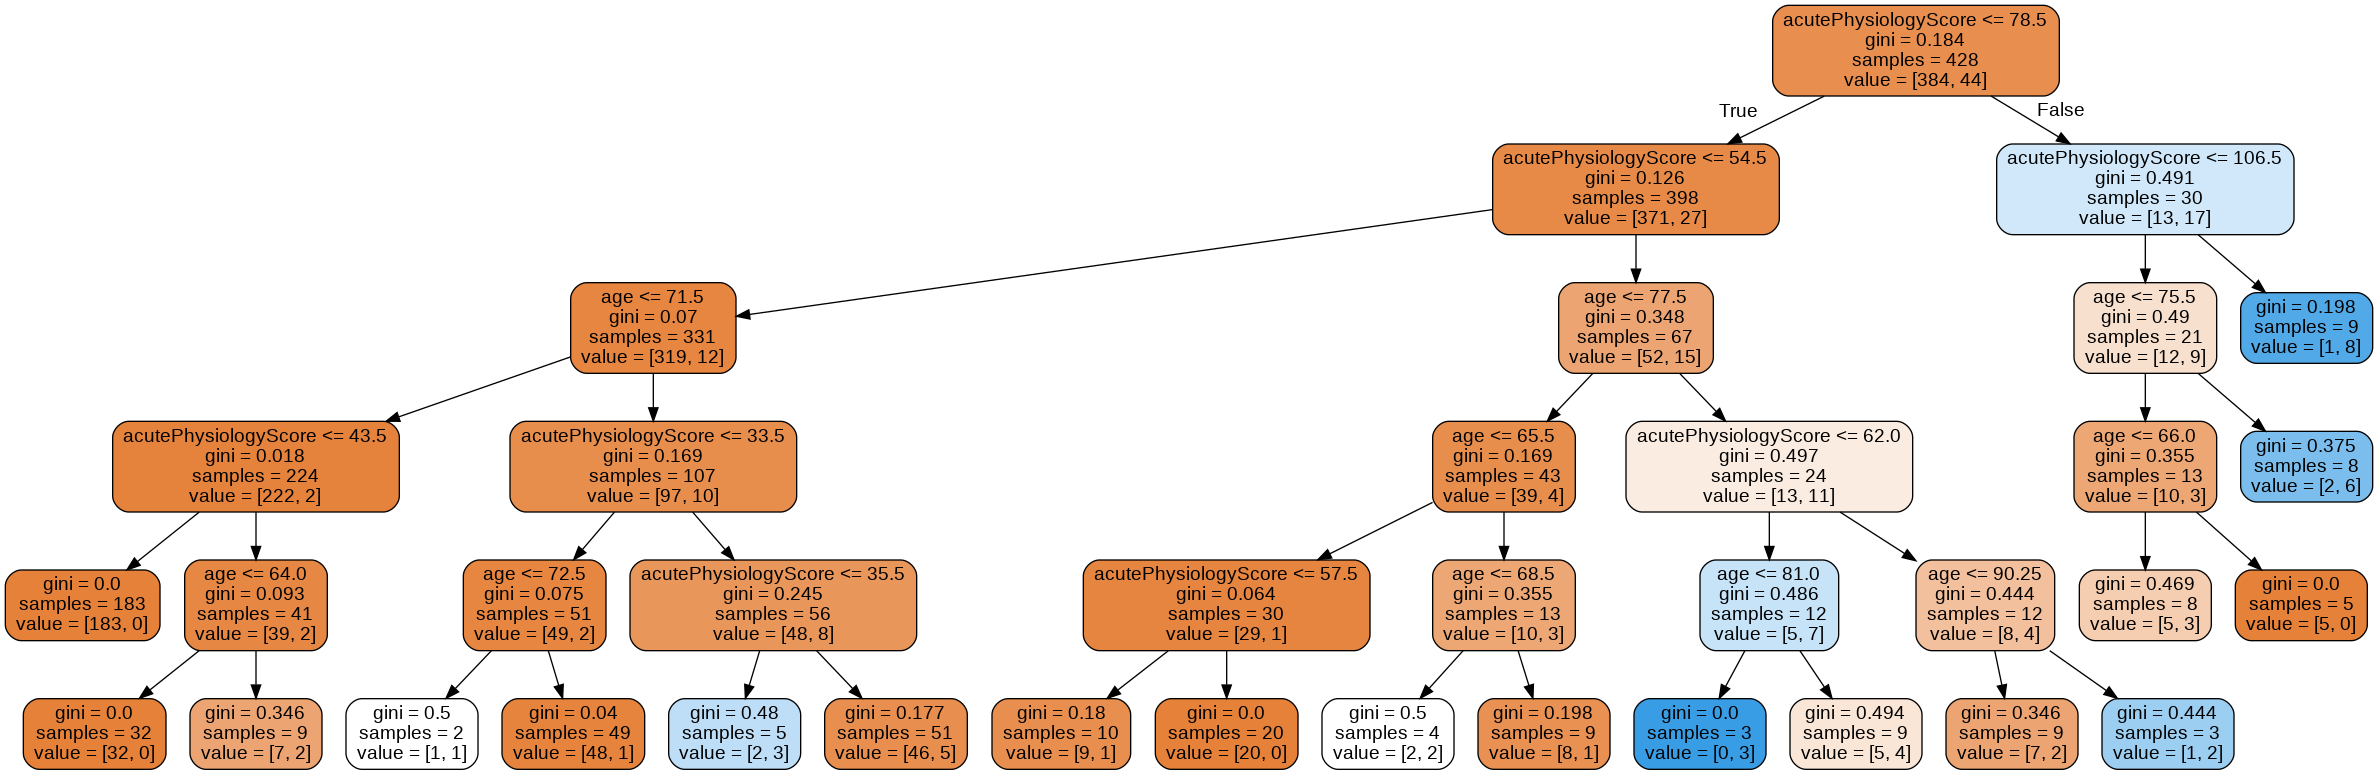

In [24]:
# let's prune the model and look again
mdl = dtn.prune(mdl, min_samples_leaf = 10)
graph = dtn.create_graph(mdl,feature_names=features)
Image(graph.create_png())  

Above, we can see that our second tree is (1) smaller in depth, and (2) never splits a node with <= 10 samples. We can look at the decision surface for this tree:

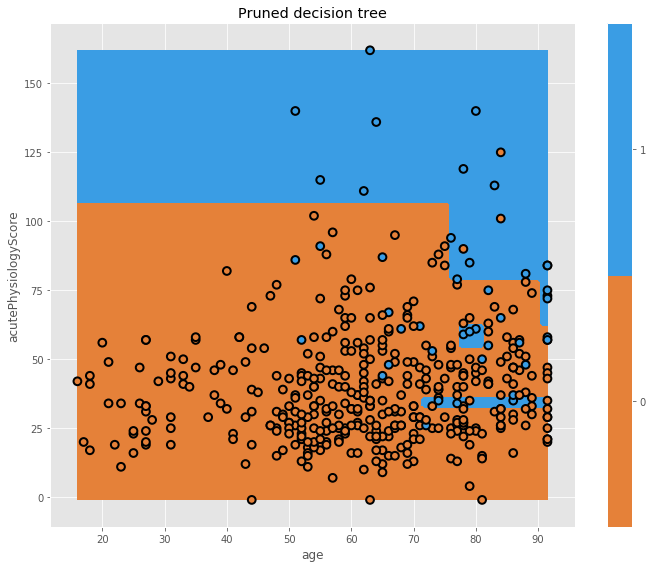

In [25]:
plt.figure(figsize=[10,8])
dtn.plot_model_pred_2d(mdl, X_train, y_train, title="Pruned decision tree")

Our pruned decision tree has a much more intuitive boundary, but does make some errors. We have reduced our performance in an effort to simplify the tree. This is the classic machine learning problem of trading off complexity with error.

Note that, in order to do this, we "invented" the minimum samples per leaf node of 10. Why 10? Why not 5? Why not 20? The answer is: it depends on the dataset. Heuristically choosing these parameters can be time consuming, and we will see later on how gradient boosting elegantly handles this task.

## Decision trees have high "variance"

Before we move on to boosting, it will be useful to demonstrate how decision trees have high "variance". In this context, variance refers to a property of some models to have a wide range of performance given random samples of data. Let's take a look at randomly slicing the data we have too see what that means.

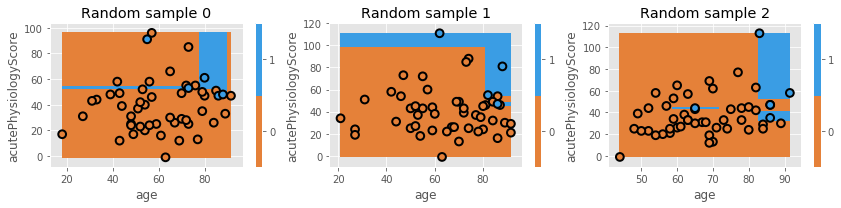

In [26]:
np.random.seed(123)

fig = plt.figure(figsize=[12,3])

for i in range(3):
    ax = fig.add_subplot(1,3,i+1)

    # generate indices in a random order
    idx = np.random.permutation(X_train.shape[0])
    
    # only use the first 50
    idx = idx[:50]
    X_temp = X_train.iloc[idx]
    y_temp = y_train.values[idx]
    
    # initialize the model
    mdl = tree.DecisionTreeClassifier(max_depth=5)
    
    # train the model using the dataset
    mdl = mdl.fit(X_temp, y_temp)
    txt = 'Random sample {}'.format(i)
    dtn.plot_model_pred_2d(mdl, X_temp, y_temp, title=txt)

Above we can see that we are using random subsets of data, and as a result, our decision boundary can change quite a bit. As you could guess, we actually don't want a model that randomly works well and randomly works poorly, so you may wonder why this is useful. 

The trick is that by combining many of instances of "high variance" classifiers (decision trees), we can end up with a single classifier with low variance. There is an old joke: two farmers and a statistician go hunting. They see a deer: the first farmer shoots, and misses to the left. The next farmer shoots, and misses to the right. The statistician yells "We got it!!".

While it doesn't quite hold in real life, it turns out that this principle does hold for decision trees. Combining them in the right way ends up building powerful models.

## Boosting

The premise of boosting is the combination of many weak learners to form a single "strong" learner. In a nutshell, boosting involves building a models iteratively. At each step we focus on the data on which we performed poorly. 

In our context, we'll use decision trees, so the first step would be to build a tree using the data. Next, we'd look at the data that we misclassified, and re-weight the data so that we really wanted to classify those observations correctly, at a cost of maybe getting some of the other data wrong this time. Let's see how this works in practice.

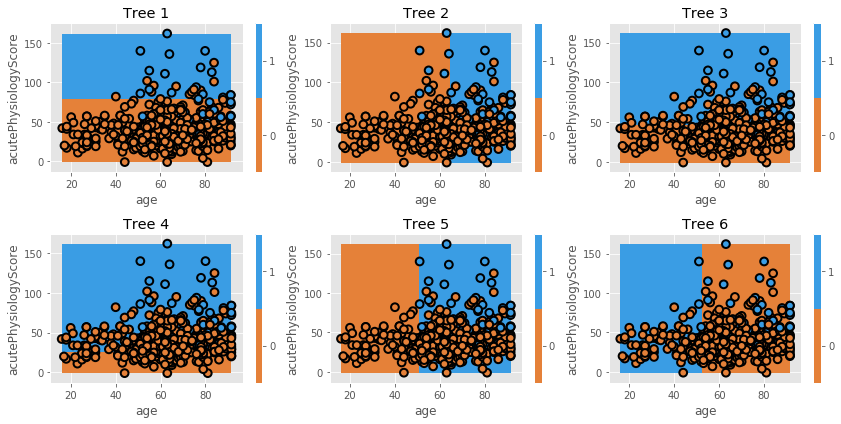

In [27]:
# build the model
clf = tree.DecisionTreeClassifier(max_depth=1)
mdl = ensemble.AdaBoostClassifier(base_estimator=clf,n_estimators=6)
mdl = mdl.fit(X_train,y_train)

# plot each individual decision tree
fig = plt.figure(figsize=[12,6])
for i, estimator in enumerate(mdl.estimators_):
    ax = fig.add_subplot(2,3,i+1)
    txt = 'Tree {}'.format(i+1)
    dtn.plot_model_pred_2d(estimator, X_train, y_train, title=txt)

Looking at our example above, we can see that the first iteration builds the exact same simple decision tree as we had seen earlier. This makes sense. It is using the entire dataset with no special weighting. 

In the next iteration we can see the model shift. It misclassified several observations in class 1, and now these are the most important observations. Consequently, it picks the boundary that, while prioritizing correctly classifies these observations, still tries to best classify the rest of the data too. 

The iteration process continues, until the model is apparently creating boundaries to capture just one or two observations (see, for example, Tree 6 on the bottom right). 

One important point is that each tree is weighted by its global error. So, for example, Tree 6 would carry less weight in the final model. It is clear that we wouldn't want Tree 6 to carry the same importance as Tree 1, when Tree 1 is doing so much better overall. It turns out that weighting each tree by the inverse of its error is a pretty good way to do this.

Let's look at final model's decision surface.


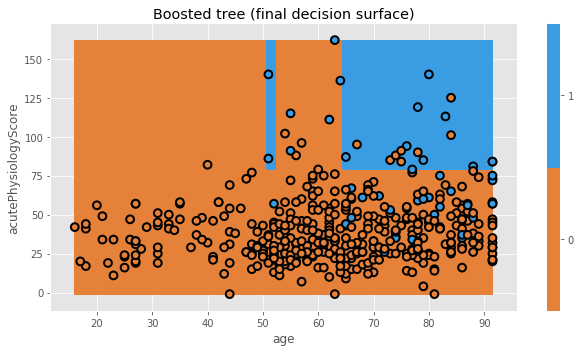

In [28]:
# plot the final prediction
plt.figure(figsize=[9,5])
txt = 'Boosted tree (final decision surface)'
dtn.plot_model_pred_2d(mdl, X_train, y_train, title=txt)

And that's AdaBoost! There are a few tricks we have glossed over here, but you understand the general principle. Now we'll move on to a different approach. With boosting, we iteratively changed the dataset to have new trees focus on the "difficult" observations. The next approach we discuss is similar as it also involves using changed versions of our dataset to build new trees.

## Bagging

Bootstrap aggregation, or "Bagging", is another form of *ensemble learning* where we aim to build a single good model by combining many models together. With AdaBoost, we modified the data to focus on hard to classify observations. We can imagine this as a form of resampling the data for each new tree. For example, say we have three observations: A, B, and C, `[A, B, C]`. If we correctly classify observations `[A, B]`, but incorrectly classify `C`, then AdaBoost involves building a new tree that focuses on `C`. Equivalently, we could say AdaBoost builds a new tree using the dataset `[A, B, C, C, C]`, where we have *intentionally* repeated observation `C` 3 times so that the algorithm thinks it is 3 times as important as the other observations. Makes sense?

Bagging involves the same approach, except we don't selectively choose which observations to focus on, but rather we *randomly select subsets of data each time*. As you can see, while this is a similar process to AdaBoost, the concept is quite different. Whereas before we aimed to iteratively improve our overall model with new trees, we now build trees on what we hope are independent datasets.

Let's take a step back, and think about a practical example. Say we wanted a good model of heart disease. If we saw researchers build a model from a dataset of patients from their hospital, we would be happy. If they then acquired a new dataset from new patients, and built a new model, we'd be inclined to feel that the combination of the two models would be better than any one individually. This exact scenario is what bagging aims to replicate, except instead of actually going out and collecting new datasets, we instead use bootstrapping to create new sets of data from our current dataset. If you are unfamiliar with bootstrapping, you can treat it as "magic" for now (and if you are familiar with the bootstrap, you already know that it is magic).

Let's take a look at a simple bootstrap model.

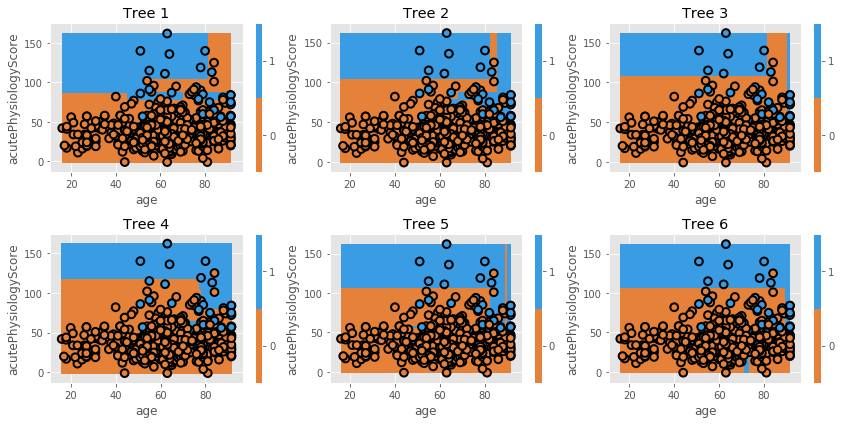

In [29]:
np.random.seed(321)
clf = tree.DecisionTreeClassifier(max_depth=5)
mdl = ensemble.BaggingClassifier(base_estimator=clf, n_estimators=6)
mdl = mdl.fit(X_train, y_train)

fig = plt.figure(figsize=[12,6])
for i, estimator in enumerate(mdl.estimators_):    
    ax = fig.add_subplot(2,3,i+1)
    txt = 'Tree {}'.format(i+1)
    dtn.plot_model_pred_2d(estimator, X_train, y_train, 
                           title=txt)

We can see that each individual tree is quite variable. This is a result of using a random set of data to train the classifier.

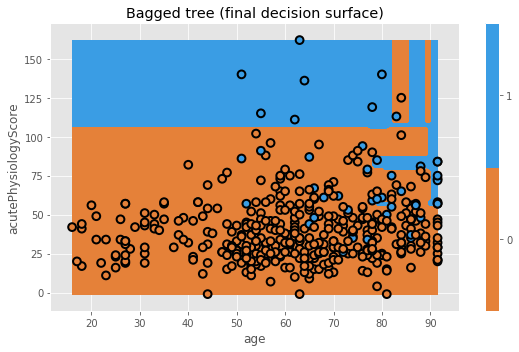

In [30]:
# plot the final prediction
plt.figure(figsize=[8,5])
txt = 'Bagged tree (final decision surface)'
dtn.plot_model_pred_2d(mdl, X_train, y_train, title=txt)

Not bad! Of course, since this is a simple dataset, we are not seeing that many dramatic changes between different models. Don't worry, we'll quantitatively evaluate them later. 

Next up, a minor addition creates one of the most popular models in machine learning.

## Random Forest

In the previous example, we used bagging to randomly resample our data to generate "new" datasets. The Random Forest takes this one step further: instead of just resampling our data, we also select only a fraction of the features to include. 

It turns out that this subselection tends to improve the performance of our models. The odds of an individual being very good or very bad is higher (i.e. the variance of the trees is increased), and this ends up giving us a final model with better overall performance (lower bias).

Let's train the model.

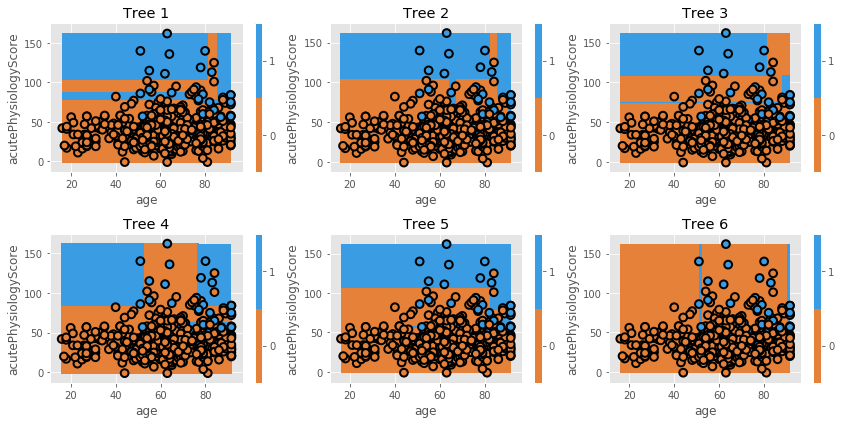

In [31]:
np.random.seed(321)
mdl = ensemble.RandomForestClassifier(max_depth=5, n_estimators=6, max_features=1)
mdl = mdl.fit(X_train,y_train)

fig = plt.figure(figsize=[12,6])
for i, estimator in enumerate(mdl.estimators_):    
    ax = fig.add_subplot(2,3,i+1)
    txt = 'Tree {}'.format(i+1)
    dtn.plot_model_pred_2d(estimator, X_train, y_train, title=txt)

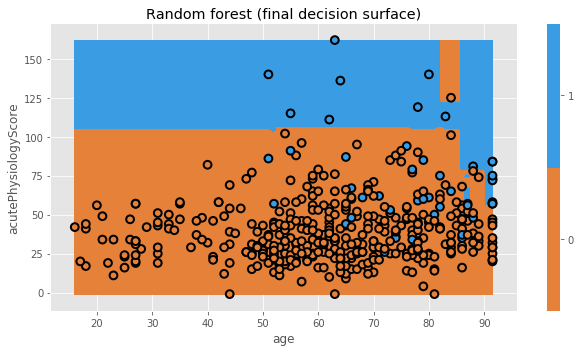

In [32]:
plt.figure(figsize=[9,5])
txt = 'Random forest (final decision surface)'
dtn.plot_model_pred_2d(mdl, X_train, y_train, title=txt)

Again, the visualization doesn't *really* show us the power of Random Forests, but we'll quantitatively evaluate them soon enough.

Last, and not least, we move on to gradient boosting.

## Gradient Boosting

Gradient boosting, our last topic, elegantly combines concepts from the previous methods. As a "boosting" method, gradient boosting involves iteratively building trees, aiming to improve upon misclassifications of the previous tree. Gradient boosting also borrows the concept of sub-sampling the variables (just like Random Forests), which can help to prevent overfitting.

While it is hard to express in this non-technical tutorial, the biggest innovation in gradient boosting is that it provides a unifying mathematical framework for boosting models. The approach explicitly casts the problem of building a tree as an optimization problem, defining mathematical functions for how well a tree is performing (which we had before) *and* how complex a tree is. In this light, one can actually treat AdaBoost as a "special case" of gradient boosting, where the loss function is chosen to be the exponential loss.

Let's build a gradient boosting model.

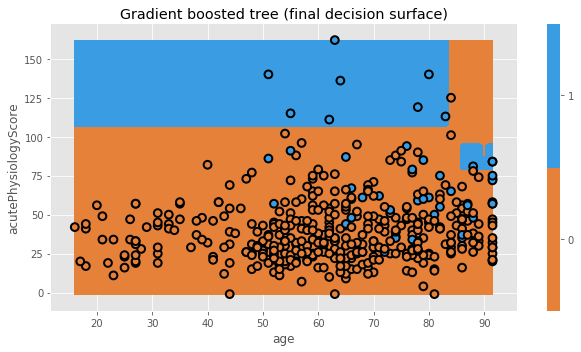

In [33]:
np.random.seed(321)
mdl = ensemble.GradientBoostingClassifier(n_estimators=10)
mdl = mdl.fit(X_train, y_train)

plt.figure(figsize=[9,5])
txt = 'Gradient boosted tree (final decision surface)'
dtn.plot_model_pred_2d(mdl, X_train, y_train, title=txt)

## Comparing model performance

We've now learned the basics of the various tree methods and have visualized most of them. Let's finish by comparing the performance of our models on our held-out test data. Our goal, remember, is to predict whether or not a patient will survive their hospital stay using the patient's age and acute physiology score computed on the first day of their ICU stay.

AUROC	Model
0.572	Decision Tree
0.910	Gradient Boosting
0.754	Random Forest
0.749	Bagging
0.686	AdaBoost


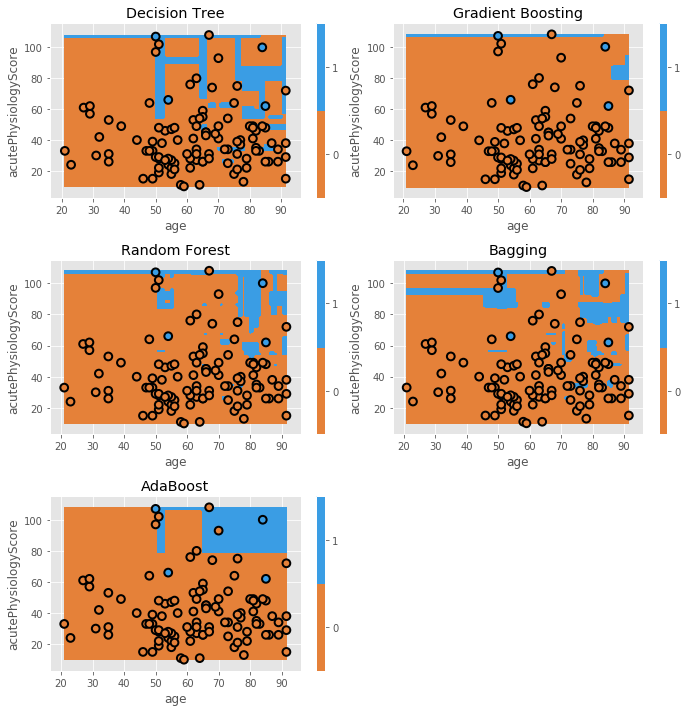

In [34]:
clf = dict()
clf['Decision Tree'] = tree.DecisionTreeClassifier(criterion='entropy', splitter='best').fit(X_train,y_train)
clf['Gradient Boosting'] = ensemble.GradientBoostingClassifier(n_estimators=10).fit(X_train, y_train)
clf['Random Forest'] = ensemble.RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
clf['Bagging'] =  ensemble.BaggingClassifier(n_estimators=10).fit(X_train, y_train)
clf['AdaBoost'] =  ensemble.AdaBoostClassifier(n_estimators=10).fit(X_train, y_train)

fig = plt.figure(figsize=[10,10])

print('AUROC\tModel')
for i, curr_mdl in enumerate(clf):    
    yhat = clf[curr_mdl].predict_proba(X_test)[:,1]
    score = metrics.roc_auc_score(y_test, yhat)
    print('{:0.3f}\t{}'.format(score, curr_mdl))
    ax = fig.add_subplot(3,2,i+1)
    dtn. plot_model_pred_2d(clf[curr_mdl], X_test, y_test, title=curr_mdl)
    

Here we can see that quantitatively, gradient boosting has produced the highest discrimination among all the models (~0.91). You'll see that some of the models appear to have simpler decision surfaces, which tends to result in improved generalization on a held-out test set (though not always!).

To make appropriate comparisons, we should calculate 95% confidence intervals on these performance estimates. This can be done a number of ways. A simple but effective approach is to use bootstrapping, a resampling technique. In bootstrapping, we generate multiple datasets from the test set (allowing the same data point to be sampled multiple times). Using these datasets, we can then estimate the confidence intervals.